Activation function with a cuff-like electrode
==============================================

This script evaluates the activation function for a cuff-like electrode

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 61
NRV INFO: Number of nodes : 3879
NRV INFO: Number of elements : 27493
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 2.42690110206604 s


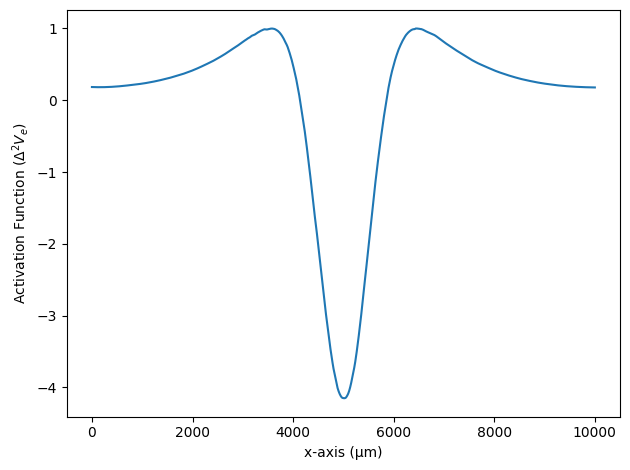

In [ ]:
import nrv
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

def move_mean(A, N):
    A = signal.savgol_filter(A, N, 3)
    #A = np.convolve(A, np.ones(N)/N, mode='valid')
    return A

def derivate(A, n_order, N=99):
    for _ in range(n_order):
        A = np.diff(A)
        A = move_mean(A, N)
    return A

if __name__ == '__main__':
    my_model = "Nerve_1_Fascicle_1_CUFF" #Optional, only if comsol is used

    ##### extracellular context
    fem_mod = nrv.FEM_stimulation()                         #if fenicsx
    #fem_mod = nrv.FEM_stimulation(model_fname=my_model)     #if comsol

    ### Simulation box size
    Outer_D = 6 #in mm

    #### Nerve and fascicle geometry
    L = 10000               #in um
    Nerve_D = 1000          #in um
    Fascicle_D = 800        #in um

    fem_mod.reshape_outerBox(Outer_D)
    fem_mod.reshape_nerve(Nerve_D, L)
    fem_mod.reshape_fascicle(Fascicle_D)

    ##### electrodes and stimuli definition
    contact_length=500          #in um
    contact_thickness=100       #in um
    insulator_length=1000       #in um
    insulator_thickness=500     #in um
    x_center = L/2

    cuff = nrv.CUFF_electrode('CUFF_1', contact_length=contact_length,\
        contact_thickness=contact_thickness, insulator_length=insulator_length,\
        insulator_thickness=insulator_thickness, x_center=x_center)

    # stimulus def
    start = 1
    I_cathod = 500
    I_anod = I_cathod/5
    T_cathod = 60e-3
    T_inter = 40e-3
    stim1 = nrv.stimulus()
    stim1.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)

    #attach stim and electrode to the FEM model
    fem_mod.add_electrode(cuff, stim1)

    ##### compute footprints
    x = np.linspace(0,L,num=1000)
    y = 0
    z = 0

    fem_mod.compute_electrodes_footprints(x, y, z, ID=0)
    ftp = cuff.footprint
    acti_function = derivate(ftp, 2)
    acti_function = acti_function/np.max(acti_function)

    fig,ax = plt.subplots(1)
    x_plot = np.linspace(0,L, len(acti_function))
    ax.plot(x_plot, acti_function)
    ax.set_ylabel(r'Activation Function ($\Delta^2V_e$)')
    ax.set_xlabel('x-axis (µm)')
    fig.tight_layout()